General idea : Compare the performance of denoising using only wavelet transform and also extracting noise using wavelet, training the model on that, and predicting type of noise.

Only wavelet transform might leave the image be cleaner than noisy image, but we have to determine if its enough

In [1]:
# Note : The current code only takes into account each individual color channel and not a combination of all.

In [2]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as compare_ssim
import tensorflow as tf
import numpy as np
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [3]:
# As size of images are different, we will resize all images into common size.
image_width = 400
image_height = 300


def load_image(image_path):
    image = cv2.imread(image_path)
    if (image is None):
        print('failed to load image with path : ', image_path)
        
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    image = cv2.resize(image, (image_width, image_height))

    print('loaded image with path : ', image_path)
          
    return image

In [4]:
# Load images from data/folder (the clean / ground truth images)
gt_image_name = 'GT_SRGB_010.png'

ground_truth_images = []

for root, dirs, files in os.walk('../data/SIDD_Small_SRGB'):
    for dir in dirs:
        folder_path = os.path.join(root, dir)

        image_path = os.path.join(folder_path, gt_image_name)
        ground_truth_images.append(load_image(image_path))

loaded image with path :  ../data/SIDD_Small_SRGB\0001_001_S6_00100_00060_3200_L\GT_SRGB_010.png
loaded image with path :  ../data/SIDD_Small_SRGB\0002_001_S6_00100_00020_3200_N\GT_SRGB_010.png
loaded image with path :  ../data/SIDD_Small_SRGB\0003_001_S6_00100_00060_3200_H\GT_SRGB_010.png
loaded image with path :  ../data/SIDD_Small_SRGB\0004_001_S6_00100_00060_4400_L\GT_SRGB_010.png
loaded image with path :  ../data/SIDD_Small_SRGB\0005_001_S6_00100_00060_4400_N\GT_SRGB_010.png
loaded image with path :  ../data/SIDD_Small_SRGB\0006_001_S6_00100_00060_4400_H\GT_SRGB_010.png
loaded image with path :  ../data/SIDD_Small_SRGB\0007_001_S6_00100_00100_5500_L\GT_SRGB_010.png
loaded image with path :  ../data/SIDD_Small_SRGB\0008_001_S6_00100_00100_5500_N\GT_SRGB_010.png
loaded image with path :  ../data/SIDD_Small_SRGB\0010_001_S6_00800_00350_3200_N\GT_SRGB_010.png
loaded image with path :  ../data/SIDD_Small_SRGB\0011_001_S6_00800_00500_5500_L\GT_SRGB_010.png
loaded image with path :  ../d

number of images :  160
dimension of each image :  (300, 400, 3)


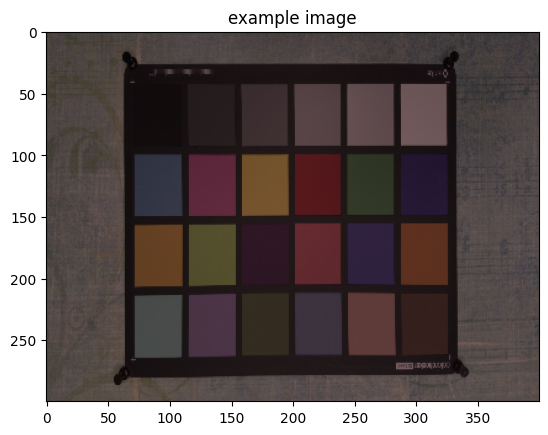

In [5]:
print('number of images : ', len(ground_truth_images))
print('dimension of each image : ', ground_truth_images[0].shape)
plt.title('example image')
plt.imshow(ground_truth_images[0])
plt.show()

In [6]:
# Load images from data/folder (the clean / ground truth images)
noisy_image_name = 'NOISY_SRGB_010.png'

noisy_images = []

for root, dirs, files in os.walk('../data/SIDD_Small_SRGB'):
    for dir in dirs:
        folder_path = os.path.join(root, dir)

        image_path = os.path.join(folder_path, noisy_image_name)
        noisy_images.append(load_image(image_path))

loaded image with path :  ../data/SIDD_Small_SRGB\0001_001_S6_00100_00060_3200_L\NOISY_SRGB_010.png
loaded image with path :  ../data/SIDD_Small_SRGB\0002_001_S6_00100_00020_3200_N\NOISY_SRGB_010.png
loaded image with path :  ../data/SIDD_Small_SRGB\0003_001_S6_00100_00060_3200_H\NOISY_SRGB_010.png
loaded image with path :  ../data/SIDD_Small_SRGB\0004_001_S6_00100_00060_4400_L\NOISY_SRGB_010.png
loaded image with path :  ../data/SIDD_Small_SRGB\0005_001_S6_00100_00060_4400_N\NOISY_SRGB_010.png
loaded image with path :  ../data/SIDD_Small_SRGB\0006_001_S6_00100_00060_4400_H\NOISY_SRGB_010.png
loaded image with path :  ../data/SIDD_Small_SRGB\0007_001_S6_00100_00100_5500_L\NOISY_SRGB_010.png
loaded image with path :  ../data/SIDD_Small_SRGB\0008_001_S6_00100_00100_5500_N\NOISY_SRGB_010.png
loaded image with path :  ../data/SIDD_Small_SRGB\0010_001_S6_00800_00350_3200_N\NOISY_SRGB_010.png
loaded image with path :  ../data/SIDD_Small_SRGB\0011_001_S6_00800_00500_5500_L\NOISY_SRGB_010.png


number of images :  160
dimension of each image :  (300, 400, 3)


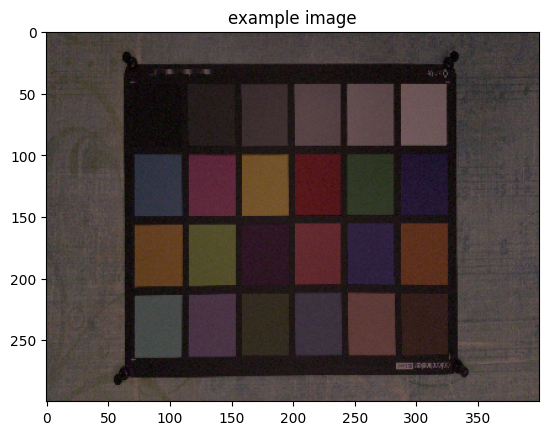

In [7]:
print('number of images : ', len(noisy_images))
print('dimension of each image : ', noisy_images[0].shape)
plt.title('example image')
plt.imshow(noisy_images[0])
plt.show()

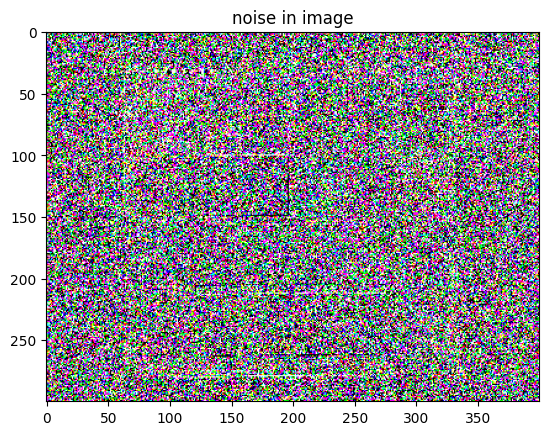

In [8]:
plt.title('noise in image')
plt.imshow(noisy_images[0] - ground_truth_images[0])
plt.show()

Performing wavelet transform

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Estimated Gaussian noise standard deviation = 0.020548214615651705


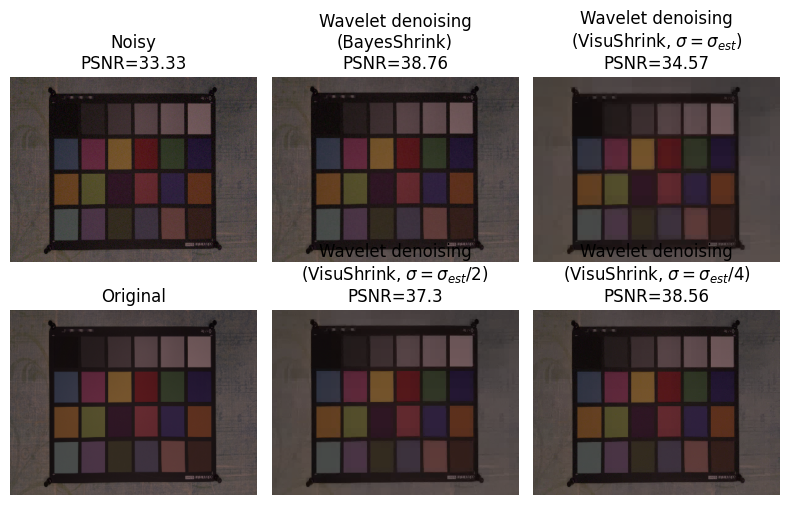

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


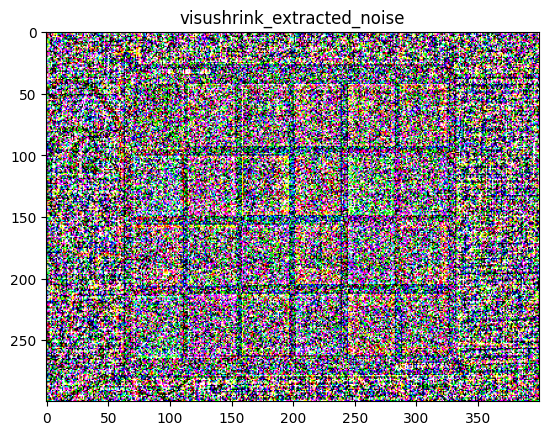

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


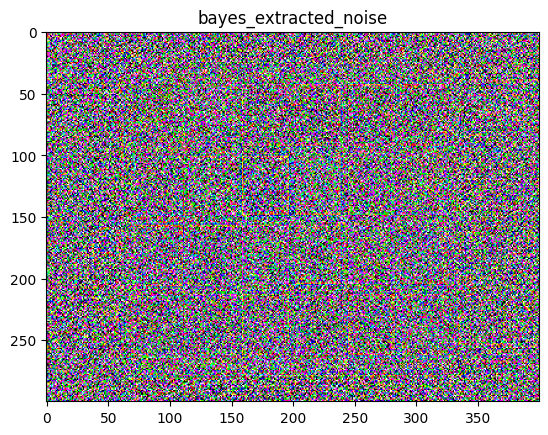

In [63]:
# Reference : https://scikit-image.org/docs/stable/auto_examples/filters/plot_denoise_wavelet.html

import matplotlib.pyplot as plt

from skimage.restoration import (denoise_wavelet, estimate_sigma)
from skimage import data, img_as_float
from skimage.util import random_noise
from skimage.metrics import peak_signal_noise_ratio

def wavelet_denoising(clean_image, noisy_image):
    clean_image = img_as_float(clean_image.copy())
    noisy_image = img_as_float(noisy_image.copy())
    

    fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(8, 5),
                    sharex=True, sharey=True)

    plt.gray()

    sigma_est = estimate_sigma(noisy_image, channel_axis=-1, average_sigmas=True)
    # Due to clipping in random_noise, the estimate will be a bit smaller than the
    # specified sigma.
    print(f'Estimated Gaussian noise standard deviation = {sigma_est}')

    im_bayes = denoise_wavelet(noisy_image, channel_axis=-1, convert2ycbcr=True,
                           method='BayesShrink', mode='soft',
                           rescale_sigma=True)
    im_visushrink = denoise_wavelet(noisy_image, channel_axis=-1, convert2ycbcr=True,
                                method='VisuShrink', mode='soft',
                                sigma=sigma_est, rescale_sigma=True)

    # VisuShrink is designed to eliminate noise with high probability, but this
    # results in a visually over-smooth appearance.  Repeat, specifying a reduction

    im_visushrink2 = denoise_wavelet(noisy_image, channel_axis=-1, convert2ycbcr=True,
                                    method='VisuShrink', mode='soft',
                                 sigma=sigma_est/2, rescale_sigma=True)
    im_visushrink4 = denoise_wavelet(noisy_image, channel_axis=-1, convert2ycbcr=True,
                                 method='VisuShrink', mode='soft',
                                 sigma=sigma_est/4, rescale_sigma=True)

    # Compute PSNR as an indication of image quality
    psnr_noisy = peak_signal_noise_ratio(clean_image, noisy_image)
    psnr_bayes = peak_signal_noise_ratio(clean_image, im_bayes)
    psnr_visushrink = peak_signal_noise_ratio(clean_image, im_visushrink)
    psnr_visushrink2 = peak_signal_noise_ratio(clean_image, im_visushrink2)
    psnr_visushrink4 = peak_signal_noise_ratio(clean_image, im_visushrink4)

    ax[0, 0].imshow(noisy_image)
    ax[0, 0].axis('off')
    ax[0, 0].set_title(f'Noisy\nPSNR={psnr_noisy:0.4g}')
    ax[0, 1].imshow(im_bayes)
    ax[0, 1].axis('off')
    ax[0, 1].set_title(
        f'Wavelet denoising\n(BayesShrink)\nPSNR={psnr_bayes:0.4g}')
    ax[0, 2].imshow(im_visushrink)
    ax[0, 2].axis('off')
    ax[0, 2].set_title(
        'Wavelet denoising\n(VisuShrink, $\\sigma=\\sigma_{est}$)\n'
         'PSNR=%0.4g' % psnr_visushrink)
    ax[1, 0].imshow(clean_image)
    ax[1, 0].axis('off')
    ax[1, 0].set_title('Original')
    ax[1, 1].imshow(im_visushrink2)
    ax[1, 1].axis('off')
    ax[1, 1].set_title(
        'Wavelet denoising\n(VisuShrink, $\\sigma=\\sigma_{est}/2$)\n'
         'PSNR=%0.4g' % psnr_visushrink2)
    ax[1, 2].imshow(im_visushrink4)
    ax[1, 2].axis('off')
    ax[1, 2].set_title(
        'Wavelet denoising\n(VisuShrink, $\\sigma=\\sigma_{est}/4$)\n'
         'PSNR=%0.4g' % psnr_visushrink4)
    fig.tight_layout()

    plt.show()
    
    return np.clip(noisy_image - im_visushrink4, 0, 1) * 255, np.clip(noisy_image -  im_bayes, 0, 1) * 255

visushrink_extracted_noise, bayes_extracted_noise = wavelet_denoising(ground_truth_images[0], noisy_images[0])

plt.title('visushrink_extracted_noise')
plt.imshow(visushrink_extracted_noise)
plt.show()

plt.title('bayes_extracted_noise')
plt.imshow(bayes_extracted_noise)
plt.show()

In [10]:
# Generation of noise images from clean image.
from enum import Enum

class NoiseTypes(Enum):
    Gaussian = 0
    SaltAndPepper = 1
    Speckle = 2
    Quantization = 3
    Poisson = 4
    Uniform = 5
    White = 6
    Gamma = 7
    Count = 8

In [36]:
import matplotlib.pyplot as plt

def show_image_pair(image1, title1, image2, title2):
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))

    # Show the first image and its histograms
    axes[0, 0].imshow(image1)
    axes[0, 0].set_title(title1)
    axes[0, 0].axis('off')
    
    for i in range(3):
        axes[0, i+1].hist(image1[:,:,i].ravel(), bins=256, color='red', alpha=0.7)
        axes[0, i+1].set_xlim([0, 255])
        axes[0, i+1].set_title(f'Channel {i} Histogram')

    # Show the second image and its histograms
    axes[1, 0].imshow(image2)
    axes[1, 0].set_title(title2)
    axes[1, 0].axis('off')

    for i in range(3):
        axes[1, i+1].hist(image2[:,:,i].ravel(), bins=256, color='blue', alpha=0.7)
        axes[1, i+1].set_xlim([0, 255])
        axes[1, i+1].set_title(f'Channel {i} Histogram')

    plt.tight_layout()

    plt.show()


In [12]:
# Reference : https://medium.com/@ms_somanna/guide-to-adding-noise-to-your-data-using-python-and-numpy-c8be815df524
# Reference : https://theailearner.com/2019/05/07/add-different-noise-to-an-image/
# Reference : https://www.kaggle.com/code/chanduanilkumar/adding-and-removing-image-noise-in-python

# Range of std_deviation : 0->100
def add_gaussian_noise(channel, mean, std_deviation):
    noise = np.random.normal(mean, std_deviation, channel.shape)
    noisy_channel = channel + noise

    # Clip pixels values in range 0..255
    noisy_channel = np.clip(noisy_channel, 0, 255).astype(np.uint8)
    
    return noisy_channel

# Probability is per pixel probability of being affected by the noise.
# Range of 0..1
def add_salt_and_pepper_noise(channel, probability):
    noisy_channel = np.copy(channel)
    salt_coords = np.where(np.random.rand(*channel.shape) < probability / 2)
    pepper_coords = np.where(np.random.rand(*channel.shape) < probability / 2)
    noisy_channel[salt_coords] = 255
    noisy_channel[pepper_coords] = 0
    return noisy_channel

# Range of intensity -> 0..1
def add_speckle_noise(channel, intensity):
    noise = np.random.normal(0, intensity, channel.shape)
    noisy_channel = channel + (channel * noise)
    return noisy_channel

# Range of intensity -> 0..1
def add_quantization_noise(channel, intensity):
    intensity = np.clip(intensity, 0, 1)
    levels = 256
    
    quantization_error = np.random.uniform(-intensity / 2, intensity / 2, channel.shape)
    noisy_channel = (channel + quantization_error).astype(np.uint8)
    
    return noisy_channel

def add_poisson_noise(channel, intensity):
    noisy_channel = np.random.poisson(channel * intensity) / intensity
    return noisy_channel

def add_uniform_noise(channel, intensity):
    noise = np.random.uniform(-intensity, intensity, channel.shape)
    noisy_channel = channel + noise
    # Clip pixels values in range 0..255
    noisy_channel = np.clip(noisy_channel, 0, 255).astype(np.uint8)
    return noisy_channel

def add_white_noise(channel, intensity):
    noise = np.random.normal(0, intensity, channel.shape)
    noisy_channel = channel + noise
    return noisy_channel

def add_gamma_noise(channel, shape, scale):
    noise = np.random.gamma(shape, scale, channel.shape)
    noisy_channel = channel + noise

    # Clip pixels values in range 0..255
    noisy_channel = np.clip(noisy_channel, 0, 255).astype(np.uint8)
    
    return noisy_channel


In [13]:
gaussian_noise_images = []
salt_and_pepper_noise_images = []
speckle_noise_images = []
quantization_noise_images = []
poisson_noise_images = []
uniform_noise_images = []
white_noise_images = []
gamma_noise_images = []

# If add_to_array is false, then 
def add_noise_to_image(image, add_to_array = True):
    
    # Gaussian noise
    noisy_image = np.copy(image)

    for channel_index in range(0,image.shape[2]):
        noisy_image[:, :, channel_index] = add_gaussian_noise(noisy_image[:, :, channel_index], np.random.uniform(0, 50), np.random.uniform(0, 70))
    if add_to_array:
        gaussian_noise_images.append(noisy_image.copy())
    else:
        show_image_pair(image, 'clean', noisy_image, 'gaussian')

    # Salt and pepper noise
    noisy_image = np.copy(image)

    for channel_index in range(0, image.shape[2]):
        noisy_image[:, :, channel_index] = add_salt_and_pepper_noise(noisy_image[:, :, channel_index], np.random.uniform(0, 0.5))

    if add_to_array:
        salt_and_pepper_noise_images.append(noisy_image.copy())
    else:
        show_image_pair(image, 'clean', noisy_image, 'salt and pepper')

    # Speckle noise
    noisy_image = np.copy(image)

    for channel_index in range(0, image.shape[2]):
        noisy_image[:, :, channel_index] = add_speckle_noise(noisy_image[:, :, channel_index], np.random.uniform(0, 1.0))
        
    if add_to_array:
        speckle_noise_images.append(noisy_image.copy())
    else:
        show_image_pair(image, 'clean', noisy_image, 'speckle')

    # Quantization noise
    noisy_image = np.copy(image)

    for channel_index in range(0, image.shape[2]):
        noisy_image[:, :, channel_index] = add_quantization_noise(noisy_image[:, :, channel_index], np.random.uniform(0, 1) )
        
    if add_to_array:
        quantization_noise_images.append(noisy_image.copy())
    else:
        show_image_pair(image, 'clean', noisy_image, 'quantization')

    # Poisson noise  
    noisy_image = np.copy(image)

    for channel_index in range(0, image.shape[2]):
        noisy_image[:, :, channel_index] = add_poisson_noise(noisy_image[:, :, channel_index], np.random.uniform(0, 100))
    
    if add_to_array:
        poisson_noise_images.append(noisy_image.copy())
    else:
        show_image_pair(image, 'clean', noisy_image, 'poisson')

    # Uniform noise
    noisy_image = np.copy(image)
    
    for channel_index in range(0, image.shape[2]):
        noisy_image[:, :, channel_index] = add_uniform_noise(noisy_image[:, :, channel_index], np.random.uniform(0, 128))
        
    if add_to_array:
        uniform_noise_images.append(noisy_image.copy())
    else:
        show_image_pair(image, 'clean', noisy_image, 'uniform')

    # White noise
    noisy_image = np.copy(image)

    for channel_index in range(0, image.shape[2]):  
        noisy_image[:, :, channel_index] = add_white_noise(noisy_image[:, :, channel_index], np.random.uniform(0, 1))
        
    if add_to_array:
        white_noise_images.append(noisy_image.copy())
    else:
        show_image_pair(image, 'clean', noisy_image, 'white')

    # Gamma noise
    noisy_image = np.copy(image)

    for channel_index in range(0, image.shape[2]):    
        noisy_image[:, :, channel_index] = add_gamma_noise(noisy_image[:, :, channel_index], np.random.uniform(0, 4.0), np.random.uniform(0, 20.0))
        
    if add_to_array:
        gamma_noise_images.append(noisy_image.copy())
    else:
        show_image_pair(image, 'clean', noisy_image, 'gamma')
    

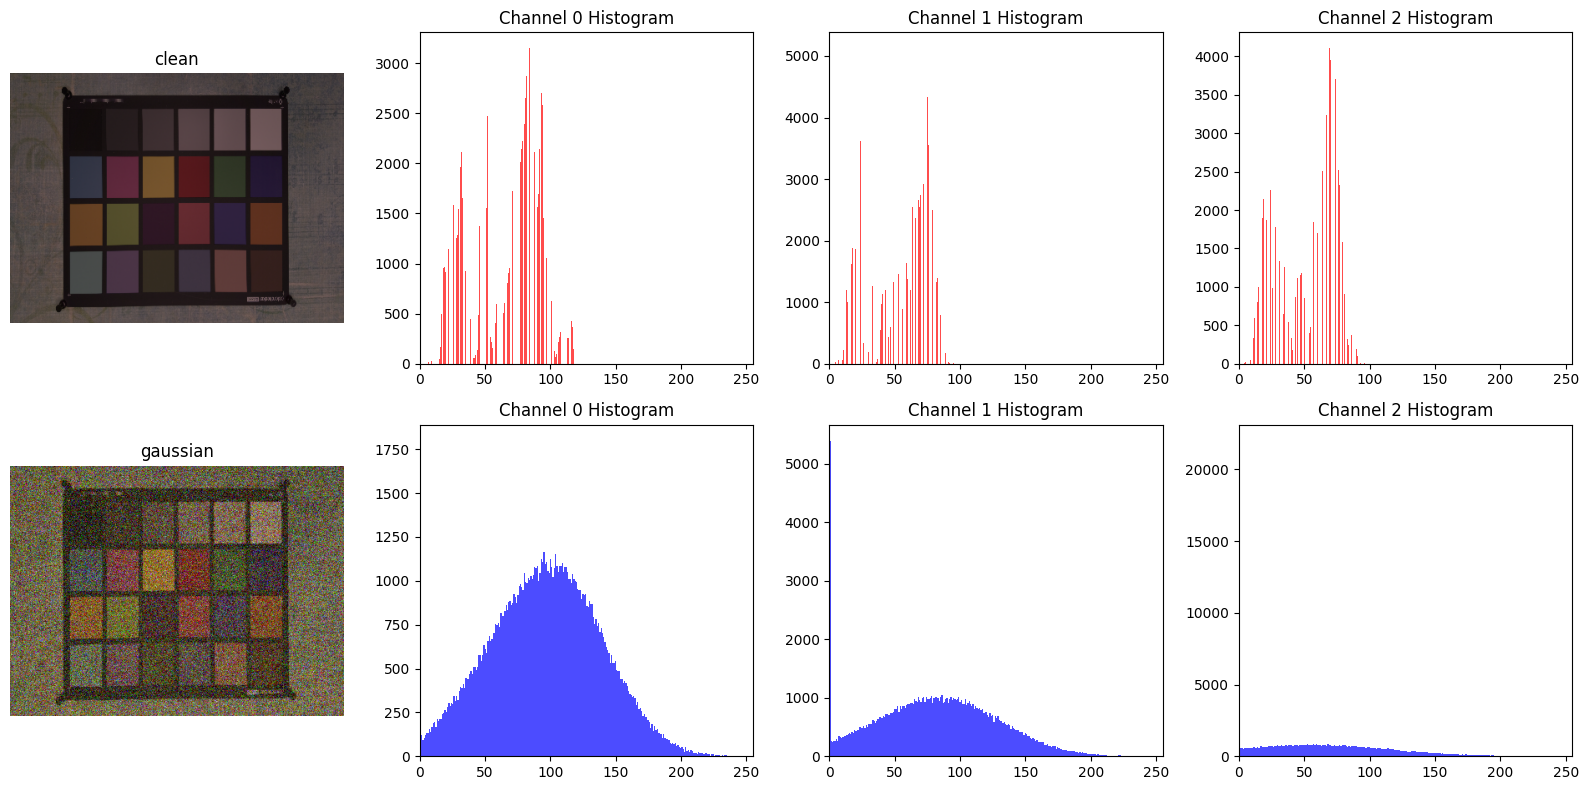

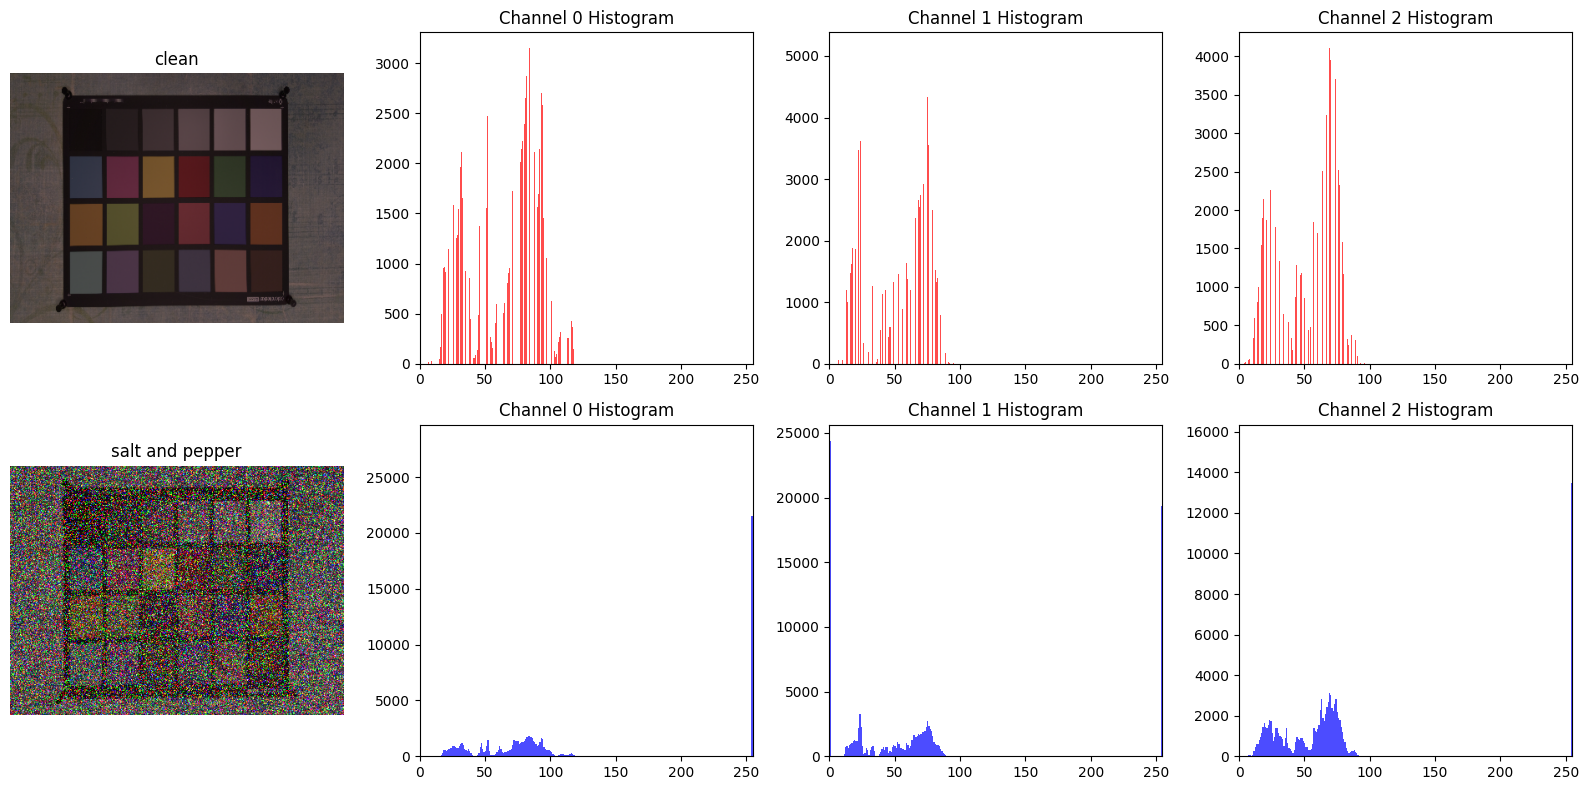

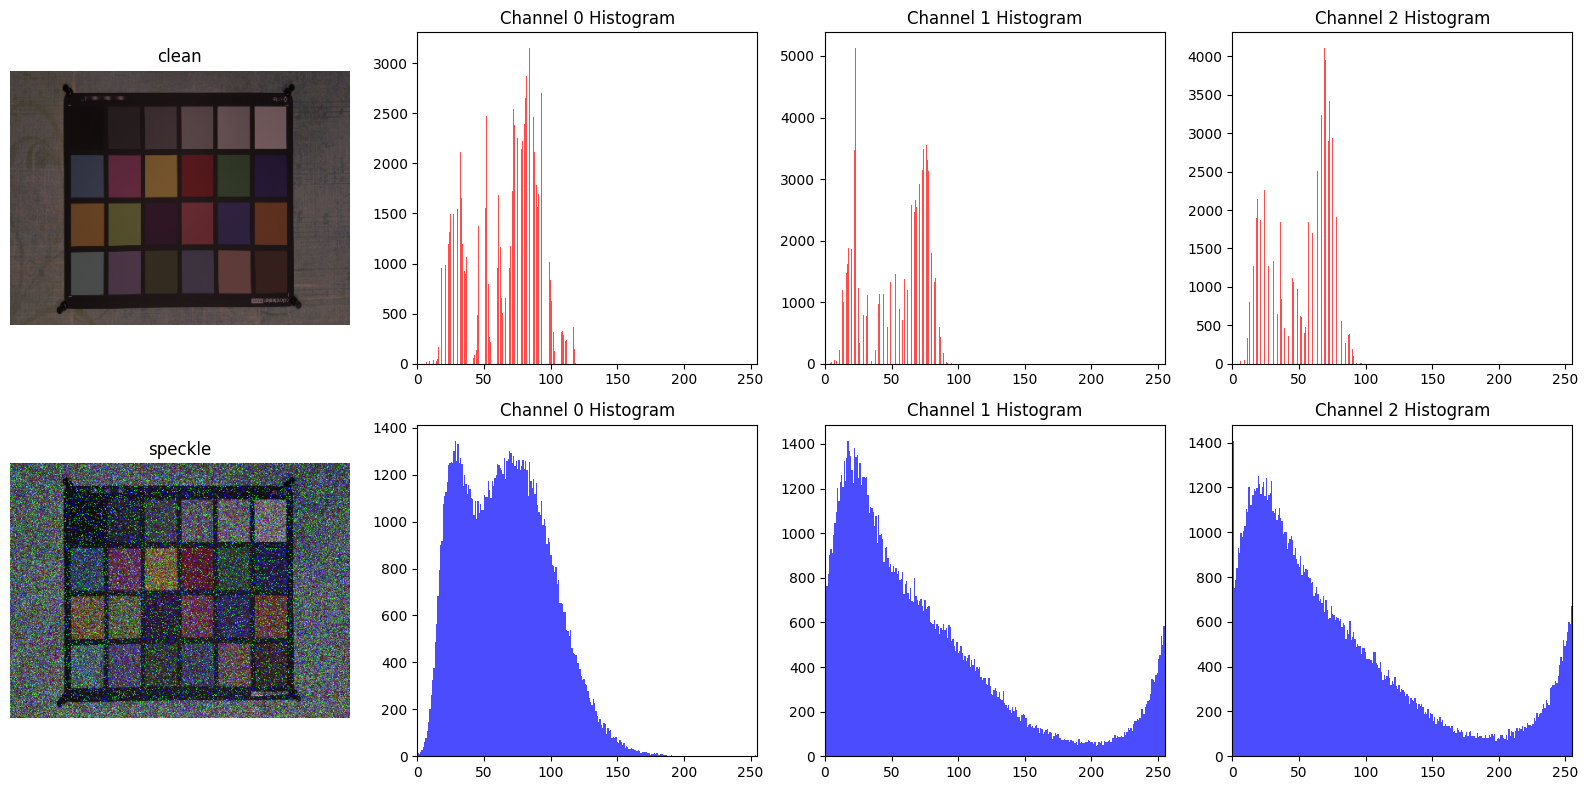

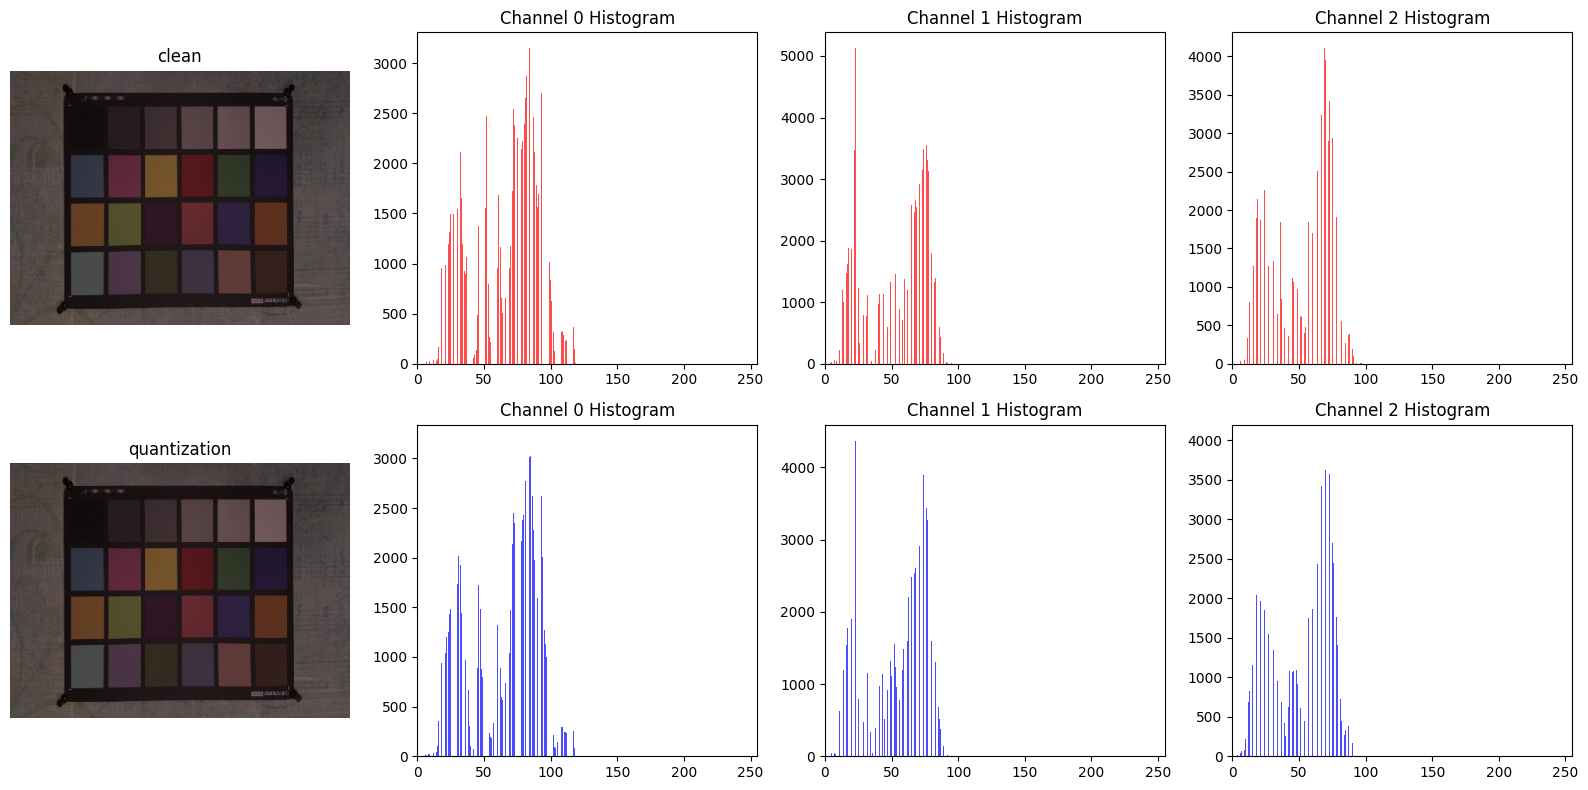

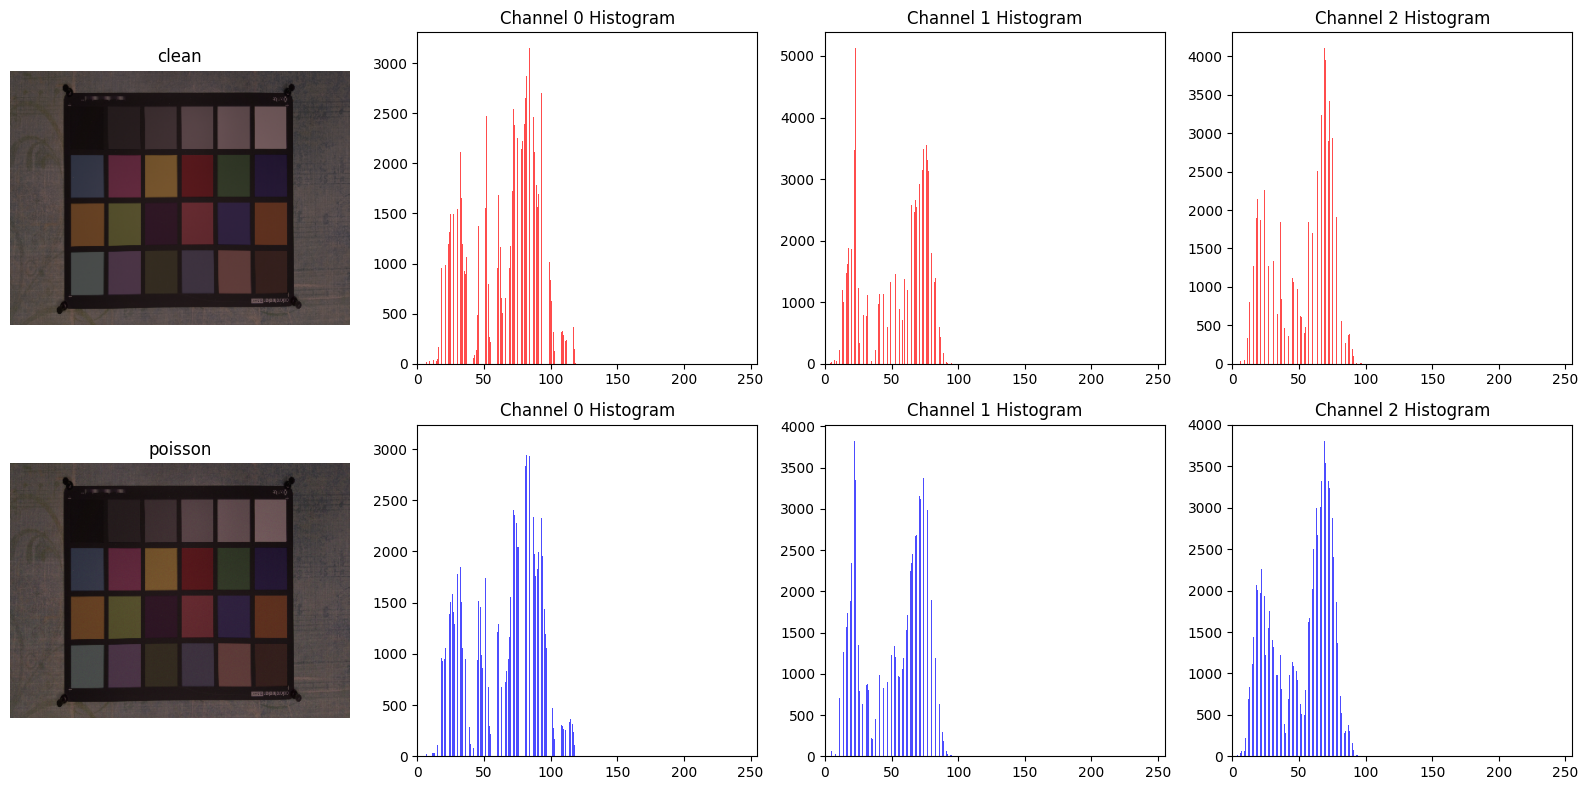

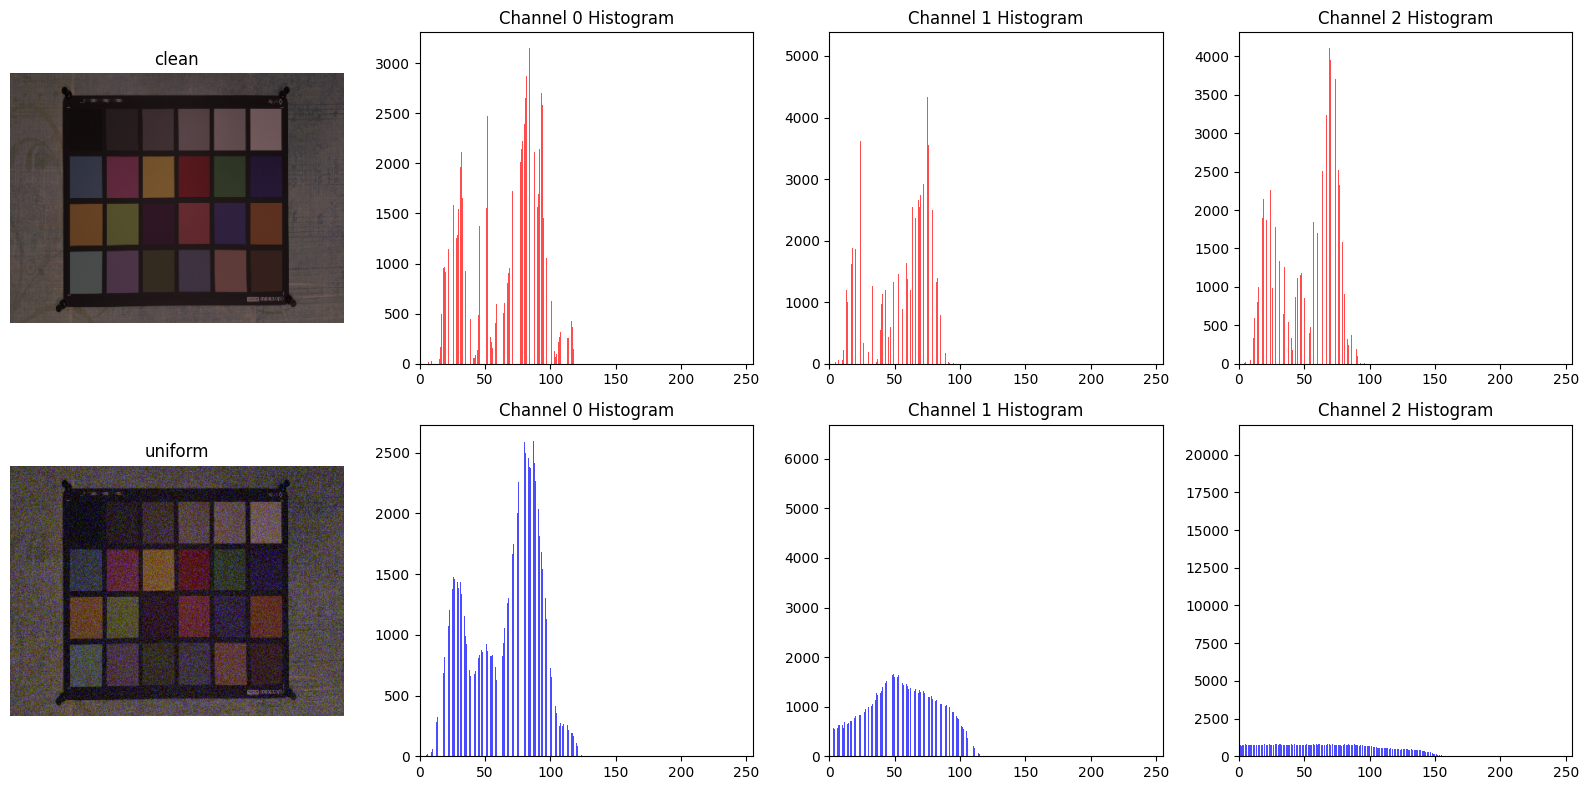

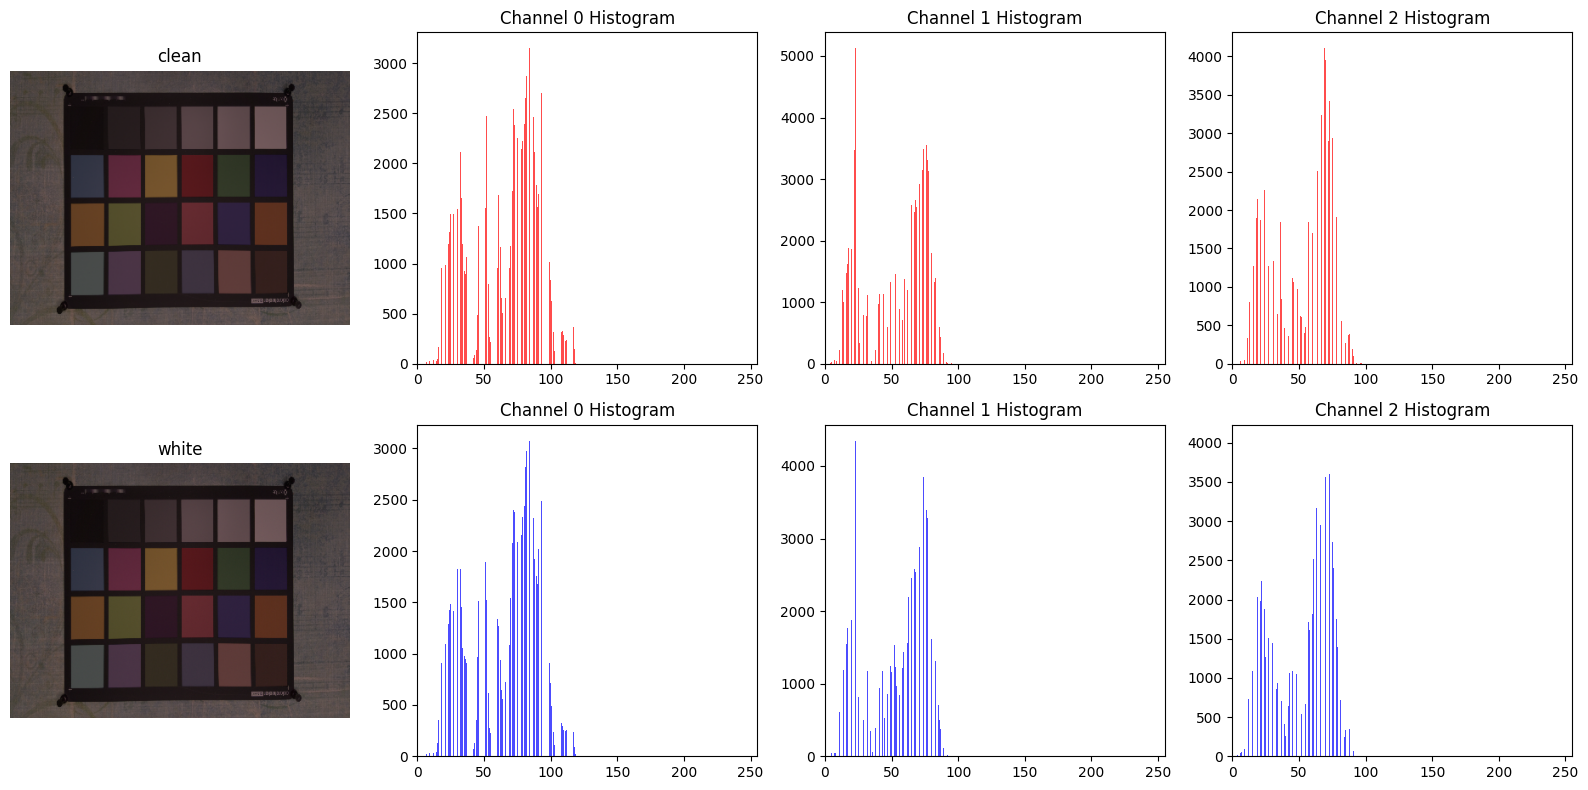

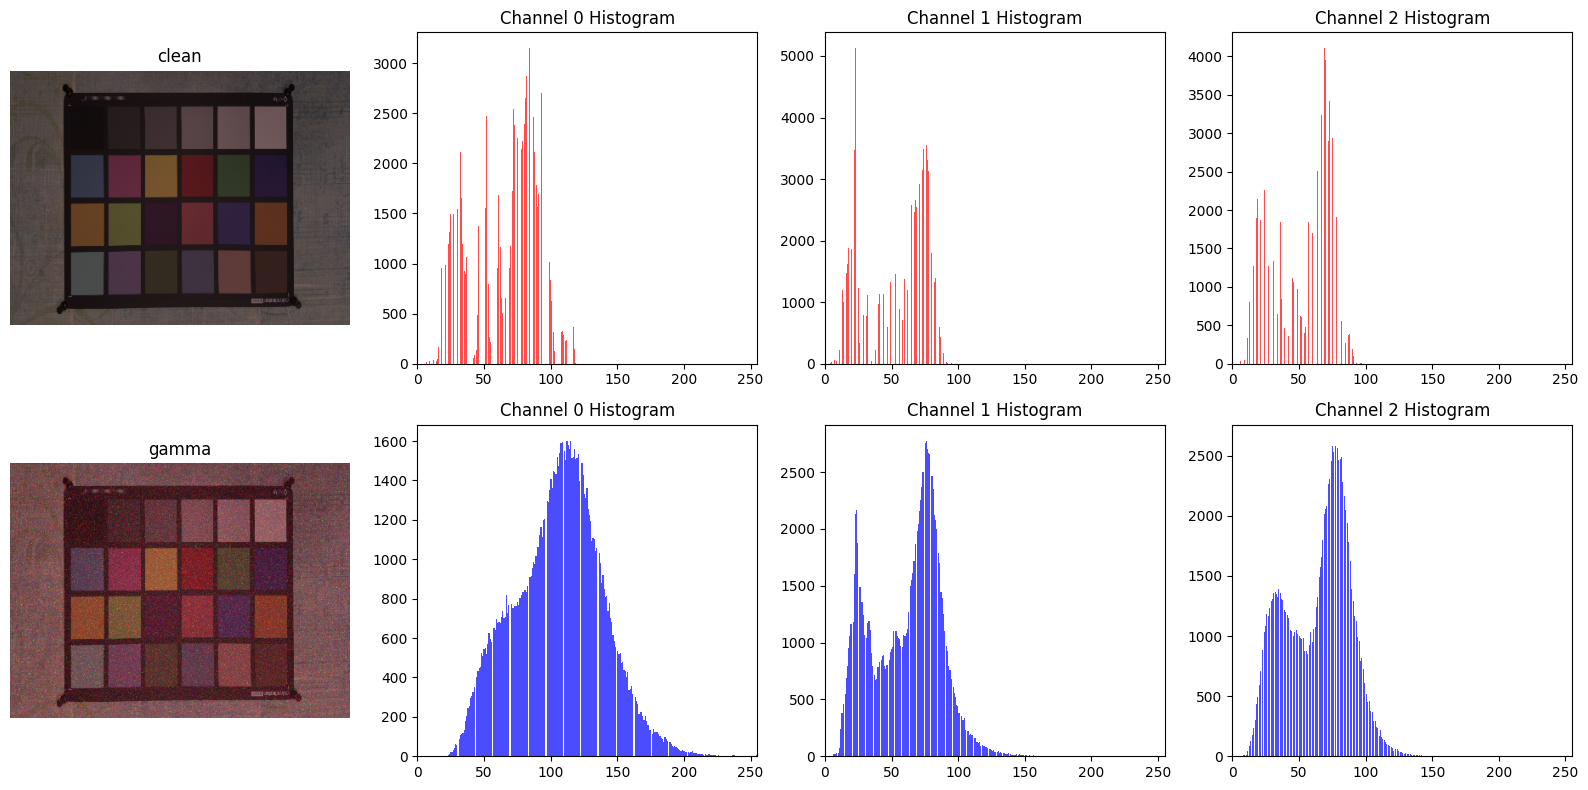

In [37]:
# Visualization (to check if the images are as expected / if range of intensity is sensible).
add_noise_to_image(ground_truth_images[0].copy(), False)

In [15]:
# Now, generate noise on black images (as we are only interested in the noise)

image_shape = (image_height, image_width, 1)

noise_patterns_to_generate = len(ground_truth_images) * 25

for i in range(0, noise_patterns_to_generate):
    add_noise_to_image(np.zeros(image_shape, dtype=np.uint8))

In [16]:
# View len of all noisy image arrays
print(len(gaussian_noise_images))
print(len(salt_and_pepper_noise_images))
print(len(speckle_noise_images))
print(len(quantization_noise_images))
print(len(poisson_noise_images))
print(len(uniform_noise_images))
print(len(white_noise_images))
print(len(gamma_noise_images))


4000
4000
4000
4000
4000
4000
4000
4000


In [17]:
# Now, create the ylabel's.

gaussian_noise_label = [NoiseTypes.Gaussian.value] * len(gaussian_noise_images) 
salt_and_pepper_noise_label = [NoiseTypes.SaltAndPepper.value] * len(salt_and_pepper_noise_images)
speckle_noise_label = [NoiseTypes.Speckle.value] * len(speckle_noise_images) 
quantization_noise_label = [NoiseTypes.Quantization.value] * len(quantization_noise_images) 
poisson_noise_label = [NoiseTypes.Poisson.value] * len(poisson_noise_images) 
uniform_noise_label = [NoiseTypes.Uniform.value] * len(uniform_noise_images) 
white_noise_label = [NoiseTypes.White.value] * len(white_noise_images) 
gamma_noise_label = [NoiseTypes.Gamma.value] * len(gamma_noise_images) 

In [18]:
# Now, the train test split can be done.
all_noise_images = np.concatenate([
    gaussian_noise_images,
    salt_and_pepper_noise_images,
    speckle_noise_images,
    quantization_noise_images,
    poisson_noise_images,
    uniform_noise_images,
    white_noise_images,
    gamma_noise_images
])

all_noise_labels = np.concatenate([
    gaussian_noise_label,
    salt_and_pepper_noise_label,
    speckle_noise_label,
    quantization_noise_label,
    poisson_noise_label,
    uniform_noise_label,
    white_noise_label,
    gamma_noise_label
])

print(len(all_noise_images), len(all_noise_labels))

from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(all_noise_images, all_noise_labels, test_size=0.2, random_state=42)


32000 32000


In [19]:
# Split train data into train and validation 
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)


In [20]:
print('x_train : ', len(x_train))
print('y_train : ', len(y_train))

print('x_val : ', len(x_val))
print('y_val : ', len(y_val))

print('x_test : ', len(x_test))
print('y_test : ', len(y_test))

x_train :  20480
y_train :  20480
x_val :  5120
y_val :  5120
x_test :  6400
y_test :  6400


In [21]:
# Convert all x_... data into histograms (channels are sepearted here).

# Define the number of bins for each channel
num_bins = 256

def extract_histograms(image_list):
    histograms = []
    for image in image_list:
        
        if image.dtype != np.uint8:
            image = (image * 255).astype(np.uint8)
        
        for i in range(0, image.shape[2]):

            hist = cv2.calcHist([image[:,:,i]], [0], None, [num_bins], [0, 256])

            hist = hist / hist.sum()

            histograms.append(hist.flatten())

    return np.array(histograms)

In [22]:
x_train_histograms = extract_histograms(x_train)
x_test_histograms = extract_histograms(x_test)
x_val_histograms = extract_histograms(x_val)

In [23]:
print(x_train_histograms.shape)
print(y_train.shape)

(20480, 256)
(20480,)


In [24]:
from tensorflow.keras.utils import to_categorical

y_train, y_test, y_val = to_categorical(y_train, NoiseTypes.Count.value), to_categorical(y_test, NoiseTypes.Count.value), to_categorical(y_val, NoiseTypes.Count.value)  # One-hot encode labels

In [25]:
print('types of noise', NoiseTypes.Count.value)

types of noise 8


In [29]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

num_classes = NoiseTypes.Count.value

num_bins = 256  
num_channels = 1 
input_shape = (num_bins * num_channels,)

# Create a sequential model
model = Sequential()

# Add input layer
model.add(layers.Input(shape=input_shape))

# Add hidden layers
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(32, activation='relu'))

model.add(layers.Dense(num_classes, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 256)               65792     
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 128)               32896     
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 32)                4128      
                                                                 
 dense_6 (Dense)             (None, 8)                 264       
                                                                 
Total params: 103080 (402.66 KB)
Trainable params: 103

In [30]:
# Train the model
hist = model.fit(x_train_histograms, y_train, epochs=20, validation_data=(x_val_histograms, y_val))

Epoch 1/20
640/640 [==============================] - 3s 3ms/step - loss: 1.1992 - accuracy: 0.4808 - val_loss: 0.8148 - val_accuracy: 0.6316
Epoch 2/20
640/640 [==============================] - 2s 3ms/step - loss: 0.8010 - accuracy: 0.6322 - val_loss: 0.7226 - val_accuracy: 0.6584
Epoch 3/20
640/640 [==============================] - 2s 3ms/step - loss: 0.7151 - accuracy: 0.6589 - val_loss: 0.6721 - val_accuracy: 0.6781
Epoch 4/20
640/640 [==============================] - 2s 3ms/step - loss: 0.6755 - accuracy: 0.6728 - val_loss: 0.6311 - val_accuracy: 0.6908
Epoch 5/20
640/640 [==============================] - 2s 3ms/step - loss: 0.6551 - accuracy: 0.6806 - val_loss: 0.6205 - val_accuracy: 0.6945
Epoch 6/20
640/640 [==============================] - 2s 3ms/step - loss: 0.6454 - accuracy: 0.6880 - val_loss: 0.6294 - val_accuracy: 0.6816
Epoch 7/20
640/640 [==============================] - 2s 3ms/step - loss: 0.6296 - accuracy: 0.6900 - val_loss: 0.6181 - val_accuracy: 0.6891
Epoch 

In [31]:
print(hist.history)

{'loss': [1.1992031335830688, 0.8010097742080688, 0.7151204347610474, 0.6755312085151672, 0.6551129221916199, 0.6453654170036316, 0.6296194195747375, 0.6290897130966187, 0.6211010217666626, 0.6200653314590454, 0.6152849197387695, 0.6125990152359009, 0.6111493110656738, 0.6067495942115784, 0.6057478785514832, 0.6042145490646362, 0.6016368865966797, 0.6014347076416016, 0.5998693704605103, 0.5959945917129517], 'accuracy': [0.48076170682907104, 0.6322265863418579, 0.658886730670929, 0.6727539300918579, 0.680615246295929, 0.68798828125, 0.689990222454071, 0.6871582269668579, 0.68701171875, 0.6890624761581421, 0.6925293207168579, 0.691699206829071, 0.691113293170929, 0.6932617425918579, 0.693603515625, 0.695507824420929, 0.694287121295929, 0.698437511920929, 0.694384753704071, 0.6978515386581421], 'val_loss': [0.814808189868927, 0.7225608229637146, 0.6720772981643677, 0.6310956478118896, 0.6204543113708496, 0.6293847560882568, 0.6181426644325256, 0.6165106892585754, 0.6029586791992188, 0.603

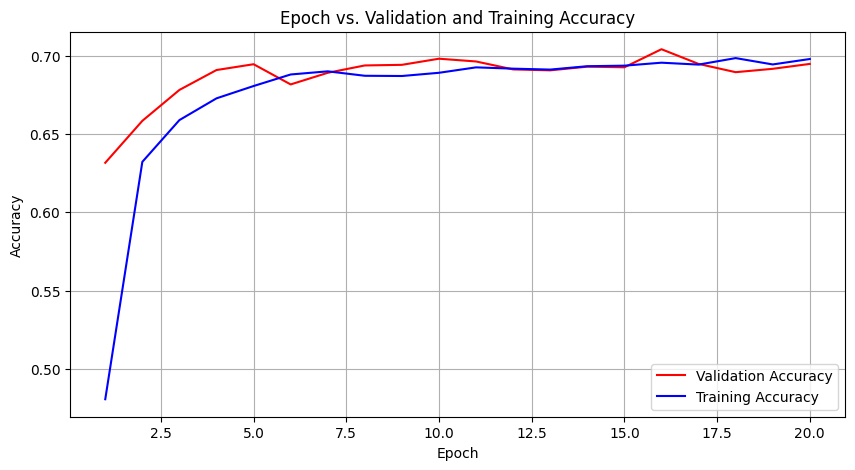

In [32]:
import matplotlib.pyplot as plt
print(hist)

val_acc = hist.history['val_accuracy']
train_acc = hist.history['accuracy']

epochs = range(1, len(hist.history['val_accuracy']) + 1)

plt.figure(figsize=(10, 5))
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.plot(epochs, train_acc, 'b', label='Training Accuracy')
plt.title('Epoch vs. Validation and Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


In [89]:
testing_loss, testing_accuracy = model.evaluate(x_test_histograms, y_test)

print("Testing Loss:", testing_loss)
print("Testing Accuracy:", testing_accuracy)


200/200 [==============================] - 1s 3ms/step - loss: 0.5865 - accuracy: 0.6972
Testing Loss: 0.5865405797958374
Testing Accuracy: 0.6971874833106995


In [90]:
import cv2
import numpy as np

scaled_channels = []
for channel in range(3):
    channel_data = bayes_extracted_noise[:, :, channel]
    max_value = np.max(channel_data)
    
    if max_value != 0:
        scaled_channel = (channel_data / max_value) * 255
    else:
        scaled_channel = channel_data

    scaled_channels.append(scaled_channel.astype(np.uint8))

scaled_bayes_extracted_noise = cv2.merge(scaled_channels)

[[[  0  59   0]
  [  0   0  40]
  [  0   0   0]
  ...
  [ 27  37   0]
  [  0  72   0]
  [  0   0   0]]

 [[  0   0  52]
  [ 89   0 113]
  [ 46  97   0]
  ...
  [ 17   0  65]
  [  0   0  30]
  [ 93  64  52]]

 [[  0 134   0]
  [ 47   0   0]
  [  0   0 134]
  ...
  [  0  98   0]
  [  0   0   0]
  [ 88  56  47]]

 ...

 [[  0   0   0]
  [  0  83  43]
  [ 10  49  74]
  ...
  [ 24   1 153]
  [  0  50   2]
  [ 52  42   0]]

 [[103  65   0]
  [  3  15   0]
  [ 60   0  25]
  ...
  [ 46   0   0]
  [  0   0   0]
  [  4   0   0]]

 [[ 47   0   0]
  [  0  88   0]
  [  0   0  10]
  ...
  [  0 126   0]
  [  0   7   6]
  [  0  38  94]]]


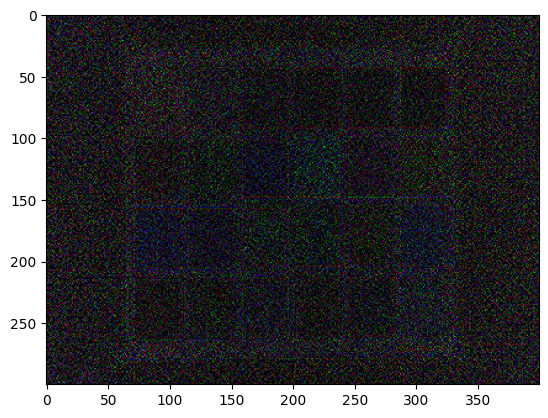

In [91]:
plt.imshow(scaled_bayes_extracted_noise)
print(scaled_bayes_extracted_noise)

In [92]:

import cv2

bayes_extracted_noise_hist = []


# Calculate and append histograms for each channel
hist_r = cv2.calcHist([scaled_bayes_extracted_noise[:, :, 0]], [0], None, [256], [0, 256])
hist_g = cv2.calcHist([scaled_bayes_extracted_noise[:, :, 1]], [0], None, [256], [0, 256])
hist_b = cv2.calcHist([scaled_bayes_extracted_noise[:, :, 2]], [0], None, [256], [0, 256])

bayes_extracted_noise_hist = [hist_r / np.sum(hist_r), hist_g / np.sum(hist_g), hist_b / np.sum(hist_b)]


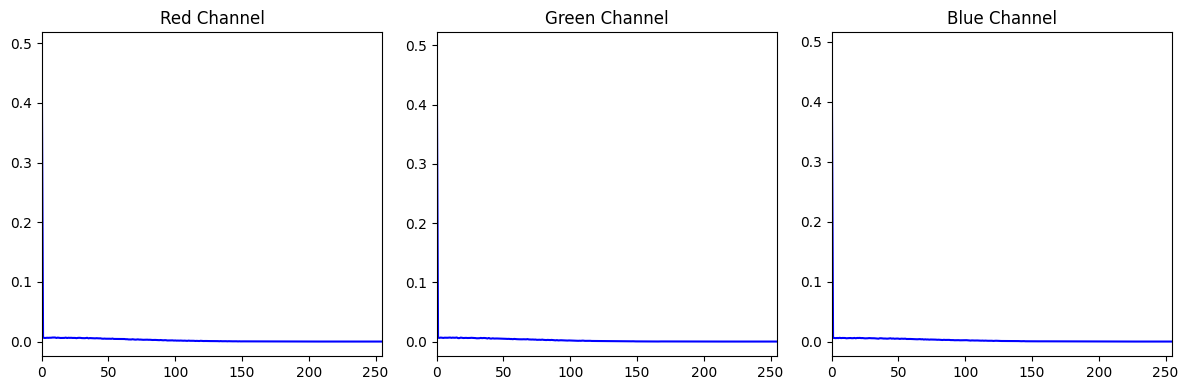

In [94]:
import matplotlib.pyplot as plt

# Create subplots for each channel's histogram
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# Set titles for each subplot
channel_titles = ['Red Channel', 'Green Channel', 'Blue Channel']

# Plot histograms for each channel
for i, hist in enumerate(bayes_extracted_noise_hist):
    axes[i].plot(hist, color='blue')
    axes[i].set_xlim([0, 255])  # Set the x-axis limits from 0 to 255
    axes[i].set_title(channel_titles[i])

plt.tight_layout()
plt.show()


In [102]:
print(model.input_shape)
print(bayes_extracted_noise_hist[0].shape)
reshaped_data = bayes_extracted_noise_hist[0].reshape(1, -1)

r_predict = model.predict(reshaped_data)

g_predict = model.predict(bayes_extracted_noise_hist[1].reshape(1, -1))
b_predict = model.predict(bayes_extracted_noise_hist[2].reshape(1, -1))

(None, 256)
(256, 1)
1/1 [==============================] - 0s 43ms/step


In [105]:
print('r predict : ', np.argmax(r_predict))
print('g predict : ', np.argmax(g_predict))
print('b predict : ', np.argmax(b_predict))

r predict :  0
g predict :  0
b predict :  0
